In [1]:
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import pandas as pd

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
f = pd.read_csv('df_data.csv')
df = pd.DataFrame(f)

In [5]:
# The 5 variables plus the target variable
df = df[['euribor3m', 'cons.conf.idx', 'age', 'previous', 'blue_collar', 'target']]

# Scaling Explanatory Variables

In [6]:
y = df.pop('target')

In [7]:
X = df

In [8]:
X.columns

Index(['euribor3m', 'cons.conf.idx', 'age', 'previous', 'blue_collar'], dtype='object')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=8)

In [10]:
scaler = MinMaxScaler()
X_train_mm = scaler.fit_transform(X_train)
X_test_mm = scaler.transform(X_test)

In [11]:
X_train = pd.DataFrame(X_train_mm, columns=['euribor3m', 'cons.conf.idx', 'age', 'previous', 'blue_collar'])

In [12]:
X_test = pd.DataFrame(X_test_mm, columns=['euribor3m', 'cons.conf.idx', 'age', 'previous', 'blue_collar'])

In [13]:
X_train.describe()

,euribor3m,cons.conf.idx,age,previous,blue_collar
count,28823.000000,28823.000000,28823.000000,28823.000000,28823.000000
mean,0.677648,0.430109,0.283754,0.028796,0.222912
std,0.392972,0.193246,0.128394,0.082555,0.416207
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.160961,0.338912,0.185185,0.000000,0.000000
50%,0.957379,0.376569,0.259259,0.000000,0.000000
75%,0.980957,0.602510,0.370370,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


### Scoring metric

In [14]:
f1_scorer = make_scorer(f1_score)

In [15]:
kf = StratifiedKFold(n_splits=5)

# Gridsearch the 5-Variable RF & Logit Models

### Random Forest

In [16]:
rf = RandomForestClassifier(n_estimators=200, criterion='entropy', max_features='auto', min_samples_split=5, 
                            class_weight='balanced', random_state=8)

In [17]:
rf_gs_params = {'n_estimators': [150, 200, 300, 500],
                'max_features': ['log2', 'sqrt'],
                'min_samples_split': [2, 5, 10, 20, 30],
                'class_weight': [None, 'balanced']}

scorers = {
    'f1': f1_scorer
}

In [18]:
gs_rf = GridSearchCV(rf, rf_gs_params, scoring=scorers, refit='f1', cv=5, verbose=2, n_jobs=-1)
gs_rf = gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  6.7min finished


In [19]:
gs_rf.best_score_

0.4510064569981392

In [20]:
gs_rf.best_params_

{'class_weight': 'balanced',
 'max_features': 'log2',
 'min_samples_split': 30,
 'n_estimators': 300}

In [21]:
gs_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [22]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [23]:
rf.fit(X_train, y_train)
scores_rf = cross_val_score(rf, X_train, y_train, scoring=f1_scorer, cv=kf)

y_hat_train_rf = rf.predict(X_train)
y_hat_test_rf = rf.predict(X_test)

In [24]:
print("Cross-validation F1 scores on Class 1:", scores_rf)
print("Mean CV F1 scores on Class 1:", np.mean(scores_rf))

Cross-validation F1 scores on Class 1: [0.45306352 0.45804989 0.45737801 0.44936359 0.43717728]
Mean CV F1 scores on Class 1: 0.4510064569981392


In [25]:
print("Train set accuracy score:", rf.score(X_train, y_train))
print("Train set F1 score on Class 1:", f1_score(y_train, y_hat_train_rf, average='binary'))
print("Train set Cohen's kappa:", cohen_kappa_score(y_train, y_hat_train_rf))
print("Train set ROC-AUC score:", roc_auc_score(y_train, y_hat_train_rf, average='macro'))

Train set accuracy score: 0.848905388058148
Train set F1 score on Class 1: 0.5131358300726663
Train set Cohen's kappa: 0.4315515930670488
Train set ROC-AUC score: 0.7868759283490576


In [26]:
print("Test set accuracy score:", rf.score(X_test, y_test))
print("Test set F1 score on Class 1:", f1_score(y_test, y_hat_test_rf, average='binary'))
print("Test set Cohen's kappa:", cohen_kappa_score(y_test, y_hat_test_rf))
print("Test set ROC-AUC score:", roc_auc_score(y_test, y_hat_test_rf, average='macro'))

Test set accuracy score: 0.8304865214927548
Test set F1 score on Class 1: 0.4532637075718015
Test set Cohen's kappa: 0.3616918297375832
Test set ROC-AUC score: 0.7401640560524408


In [27]:
# Classification report on train set
print(classification_report(y_train, y_hat_train_rf))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91     25576
           1       0.40      0.71      0.51      3247

    accuracy                           0.85     28823
   macro avg       0.68      0.79      0.71     28823
weighted avg       0.90      0.85      0.87     28823



In [28]:
# Classification report on test set
print(classification_report(y_test, y_hat_test_rf))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     10961
           1       0.36      0.62      0.45      1392

    accuracy                           0.83     12353
   macro avg       0.65      0.74      0.68     12353
weighted avg       0.88      0.83      0.85     12353



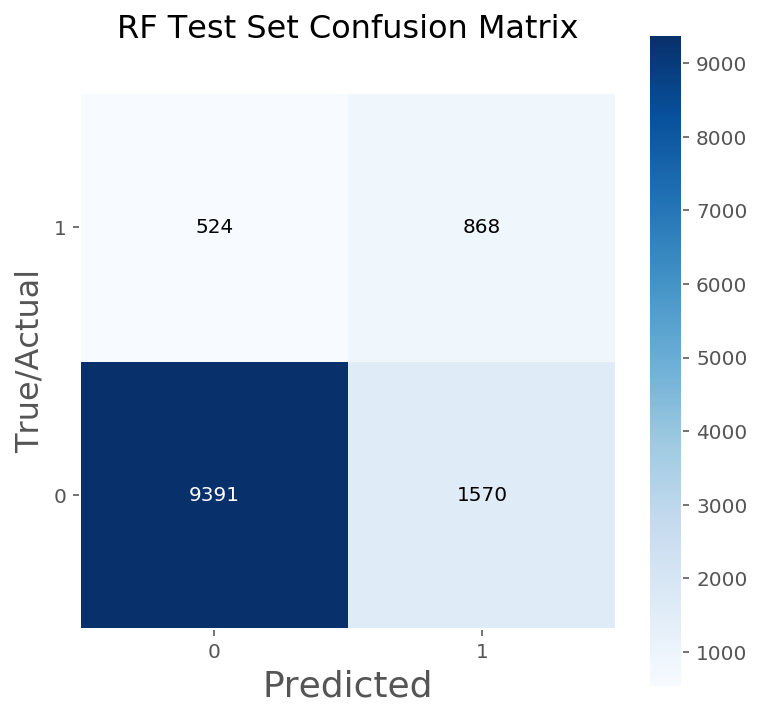

In [29]:
# Confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_rf, figsize=(6,6))
plt.title('RF Test Set Confusion Matrix', y=1.08, fontsize=16)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True/Actual', fontsize=16)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

#### The mean CV F1 scores on the train set are 0.4663 in the All-variable RF model versus 0.4510 in the 5-variable RF model above. The test set's F1 score, Cohen's kappa, and ROC-AUC score are uniformly lower for the 5-variable model compared to the All-variable one, but only marginally so.

#### The confusion matrix for the RF model above shows that it managed to predict 868 class "1" (successful subscriptions) out of a total of 524 + 868 = 1392 actual class "1" observations in the test set. That is a recall rate of 62.4%. Out of the model's predicted  2,438 class "1" observations, 868 of them proved to be true class "1", which gives a precision rate of 35.6%. These precision and recall rates contributed to an F1 score of 45.3% on the class "1" category in the test set.

#### The 5-variable model's F1 score of 45.3% is slightly smaller than the 47.6% clocked by the All-variable model, but still much better than the 29.7% of the simple Random Forest model shown in the "Campaign_II" file.

### Logistic Regression

In [30]:
logit = LogisticRegression(penalty='l2', C=1, solver='liblinear', class_weight='balanced', random_state=8)

In [31]:
logit_gs_params = {'penalty': ['l1', 'l2'],
                   'solver': ['liblinear', 'saga'],
                   'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                   'class_weight': [None, 'balanced']}

scorers = {
    'f1': f1_scorer
}

In [32]:
gs_logit = GridSearchCV(logit, logit_gs_params, scoring=scorers, refit='f1', cv=5, verbose=2, n_jobs=-1)
gs_logit = gs_logit.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    4.2s finished


In [33]:
gs_logit.best_score_

0.38305251342819435

In [34]:
gs_logit.best_params_

{'C': 0.0001,
 'class_weight': 'balanced',
 'penalty': 'l2',
 'solver': 'liblinear'}

In [35]:
gs_logit.best_estimator_

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
logit = LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
logit.fit(X_train, y_train)
scores_lr = cross_val_score(logit, X_train, y_train, scoring=f1_scorer, cv=kf)

y_hat_train_lr = logit.predict(X_train)
y_hat_test_lr = logit.predict(X_test)

In [38]:
print("Cross-validation F1 scores:", scores_lr)
print("Mean CV F1 scores:", np.mean(scores_lr))

Cross-validation F1 scores: [0.38376384 0.39197387 0.3857404  0.38055166 0.3732328 ]
Mean CV F1 scores: 0.38305251342819435


In [39]:
print("Train set accuracy score:", logit.score(X_train, y_train))
print("Train set F1 score on Class 1:", f1_score(y_train, y_hat_train_lr, average='binary'))
print("Train set Cohen's kappa:", cohen_kappa_score(y_train, y_hat_train_lr))
print("Train set ROC-AUC score:", roc_auc_score(y_train, y_hat_train_lr, average='macro'))

Train set accuracy score: 0.7694896436873331
Train set F1 score on Class 1: 0.3857248520710059
Train set Cohen's kappa: 0.2707441830846766
Train set ROC-AUC score: 0.7140292526225936


In [40]:
print("Test set accuracy score:", logit.score(X_test, y_test))
print("Test set F1 score on Class 1:", f1_score(y_test, y_hat_test_lr, average='binary'))
print("Test set Cohen's kappa:", cohen_kappa_score(y_test, y_hat_test_lr))
print("Test set ROC-AUC score:", roc_auc_score(y_test, y_hat_test_lr, average='macro'))

Test set accuracy score: 0.7722010847567392
Test set F1 score on Class 1: 0.39248704663212436
Test set Cohen's kappa: 0.27879441156128426
Test set ROC-AUC score: 0.7201770815965068


In [41]:
# Classification report on train set
print(classification_report(y_train, y_hat_train_lr))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86     25576
           1       0.28      0.64      0.39      3247

    accuracy                           0.77     28823
   macro avg       0.61      0.71      0.62     28823
weighted avg       0.87      0.77      0.80     28823



In [42]:
# Classification report on test set
print(classification_report(y_test, y_hat_test_lr))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86     10961
           1       0.28      0.65      0.39      1392

    accuracy                           0.77     12353
   macro avg       0.61      0.72      0.63     12353
weighted avg       0.87      0.77      0.81     12353



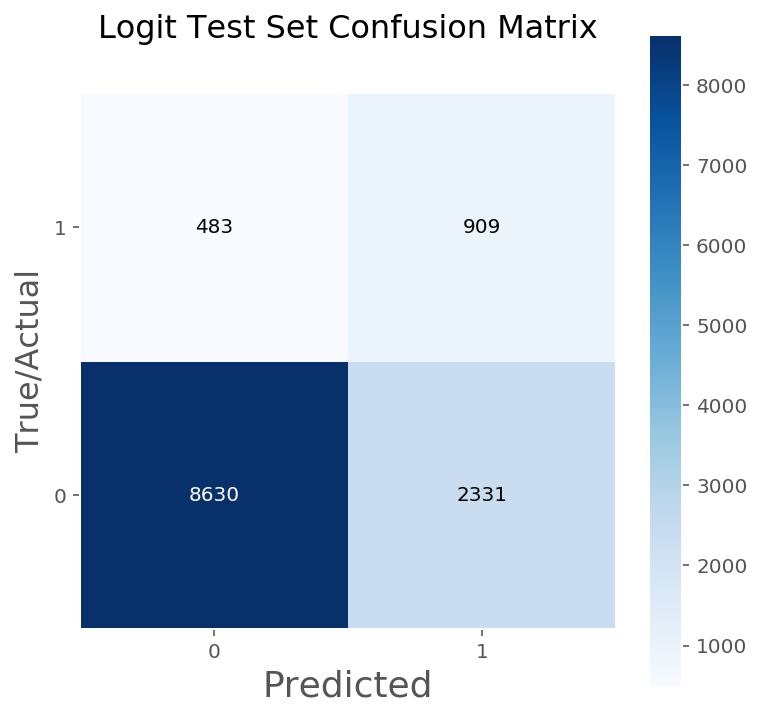

In [43]:
# Logit confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_lr, figsize=(6,6))
plt.title('Logit Test Set Confusion Matrix', y=1.08, fontsize=16)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True/Actual', fontsize=16)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

### Gridsearch Findings

#### Logit's CV F1 scores on the train set are notably weaker than those from Random Forest. Moreover, Logit's performance on the test set is also uniformly weaker. Consequently, the Random Forest Classifier again wins the crown for the 5-variable predictive model.

# RF 5-variable Model Probability Threshold

We can still see if a "soft classification" model's prediction of a minority class of interest could be improve by shifting the probability thresholds. To do so we need to obtain the model's probabilistic predictions.

In [44]:
rf.classes_

array([0, 1], dtype=int64)

In [45]:
# Obtain the the probabilistic predictions of Class 1 in the target variable, using the train set
yhat_train_prob = rf.predict_proba(X_train)[:, 1]

In [46]:
precision, recall, thresholds = precision_recall_curve(y_train, yhat_train_prob)

In [47]:
thresholds = np.append(thresholds, 1) 

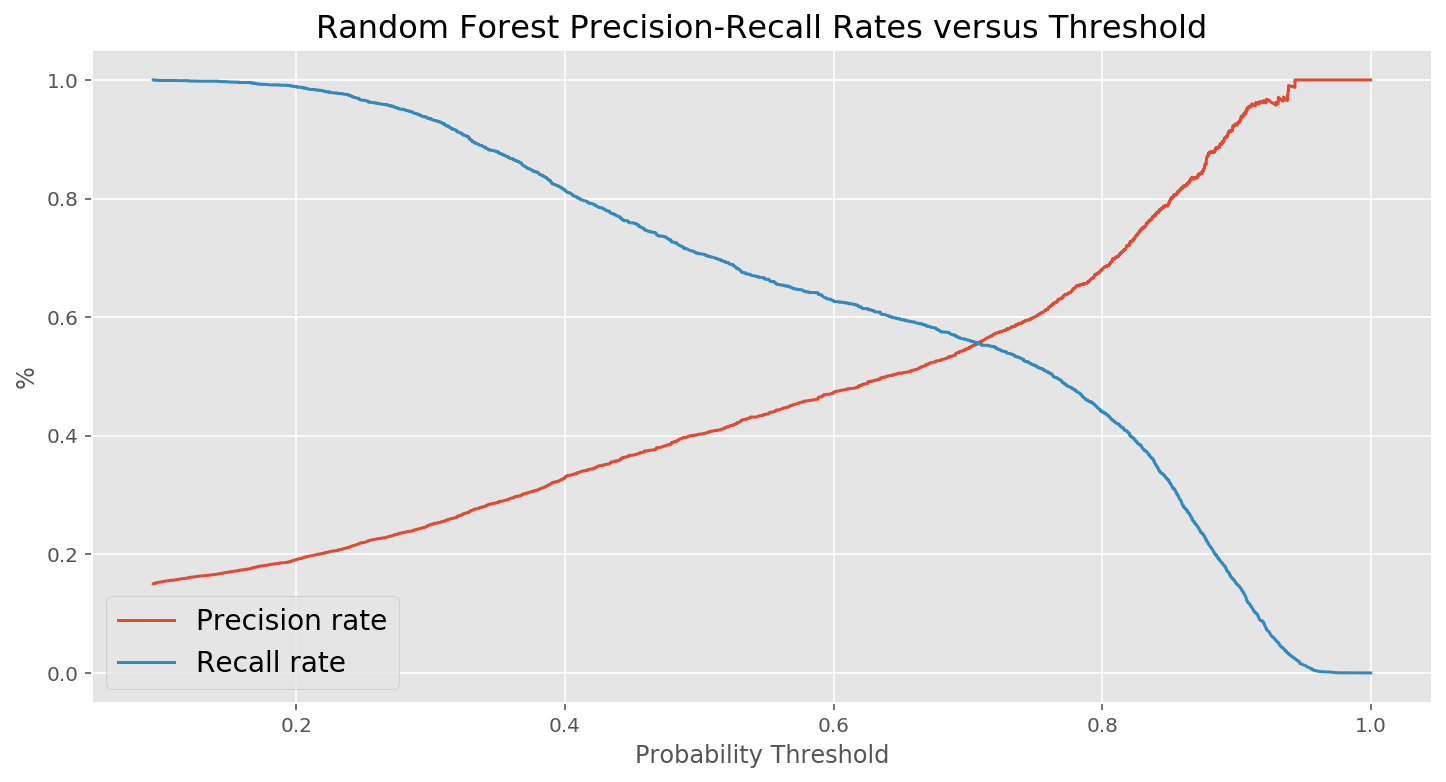

In [48]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(thresholds, precision, color=sns.color_palette()[0]) 
ax.plot(thresholds, recall, color=sns.color_palette()[1]) 
ax.legend(('Precision rate', 'Recall rate'), fontsize=14)

ax.set_title("Random Forest Precision-Recall Rates versus Threshold", fontsize=16)
ax.set_xlabel('Probability Threshold') 
ax.set_ylabel('%');

In [49]:
pr_combi = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thresholds}, 
                        columns=['precision', 'recall', 'threshold'])

In [50]:
pr_combi['f1'] = 2*(precision*recall)/(precision+recall+0.0000000000000000001)

In [51]:
# List of various precision and recall rates, and associated F1 scores, according to various probability thresholds
pr_combi

,precision,recall,threshold,f1
0,0.150234,1.000000,0.093517,0.261223
1,0.150668,0.999692,0.093596,0.261869
2,0.150689,0.999692,0.093643,0.261901
3,0.150745,0.999692,0.093738,0.261985
4,0.150752,0.999692,0.093765,0.261996
...,...,...,...,...
6672,1.000000,0.001848,0.967589,0.003689
6673,1.000000,0.001540,0.969920,0.003075
6674,1.000000,0.001232,0.970470,0.002461
6675,1.000000,0.000308,0.975810,0.000616


### Changing the threshold to improve the F1 score

In [52]:
# Find maximum F1 score
pr_combi['f1'].max()

0.5607535321821037

In [53]:
# Be mindful of the tendency of RF to overfit the training data, so let's set the threshold somewhat lower than the max
pr_combi[pr_combi.f1 > 0.55]

,precision,recall,threshold,f1
3954,0.516207,0.588543,0.665605,0.550007
3955,0.516347,0.588543,0.665904,0.550086
3956,0.516766,0.588543,0.666008,0.550324
3957,0.516635,0.588235,0.666093,0.550115
3959,0.516784,0.587927,0.666758,0.550065
...,...,...,...,...
4844,0.649476,0.477056,0.780034,0.550071
4845,0.649748,0.477056,0.780153,0.550169
4846,0.650021,0.477056,0.780193,0.550266
4847,0.650694,0.476748,0.780324,0.550302


In [54]:
# Generate the predicted probabilities on the test set
yhat_test_prob = rf.predict_proba(X_test)[:, 1]

In [55]:
# If we use the max threshold on the test set...
threshold = 0.780329
y_test_class = []
for i in range(len(yhat_test_prob)):
    if yhat_test_prob[i] > threshold:
        y_test_class.append(1)
    else:
        y_test_class.append(0)

In [56]:
len(y_test_class)

12353

In [57]:
# Weaker results as threshold is too high, as suspected
print("Test set accuracy score:", rf.score(X_test, y_test_class))
print("Test set F1 score on Class 1:", f1_score(y_test, y_test_class, average='binary'))
print("Test set Cohen's kappa:", cohen_kappa_score(y_test, y_test_class))
print("Test set ROC-AUC score:", roc_auc_score(y_test, y_test_class, average='macro'))

Test set accuracy score: 0.882376750586902
Test set F1 score on Class 1: 0.4122843920908708
Test set Cohen's kappa: 0.3517432075117386
Test set ROC-AUC score: 0.6534256905622547


In [58]:
# If we use the min threshold from the list in [53] above on the test set...
threshold = 0.665605
y_test_class = []
for i in range(len(yhat_test_prob)):
    if yhat_test_prob[i] > threshold:
        y_test_class.append(1)
    else:
        y_test_class.append(0)

In [59]:
# Also applying it to the training data...
y_train_class = []
for i in range(len(yhat_train_prob)):
    if yhat_train_prob[i] > threshold:
        y_train_class.append(1)
    else:
        y_train_class.append(0)

In [61]:
print("Train set accuracy score:", rf.score(X_train, y_train_class))
print("Train set F1 score on Class 1:", f1_score(y_train, y_train_class, average='binary'))
print("Train set Cohen's kappa:", cohen_kappa_score(y_train, y_train_class))
print("Train set ROC-AUC score:", roc_auc_score(y_train, y_train_class, average='macro'))

Train set accuracy score: 0.9307150539499706
Train set F1 score on Class 1: 0.5500863557858376
Train set Cohen's kappa: 0.48872628631866544
Train set ROC-AUC score: 0.7592778912205863


In [62]:
print("Test set accuracy score:", rf.score(X_test, y_test_class))
print("Test set F1 score on Class 1:", f1_score(y_test, y_test_class, average='binary'))
print("Test set Cohen's kappa:", cohen_kappa_score(y_test, y_test_class))
print("Test set ROC-AUC score:", roc_auc_score(y_test, y_test_class, average='macro'))

Test set accuracy score: 0.9297336679349146
Test set F1 score on Class 1: 0.474679270762998
Test set Cohen's kappa: 0.4034127875899175
Test set ROC-AUC score: 0.7129650566218578


In [63]:
print(classification_report(y_test, y_test_class))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10961
           1       0.45      0.51      0.47      1392

    accuracy                           0.87     12353
   macro avg       0.69      0.71      0.70     12353
weighted avg       0.88      0.87      0.88     12353



#### The top 5-variable RF model had the following results:
Test set accuracy score: 0.8304865214927548

Test set F1 score on Class 1: 0.4532637075718015

Test set Cohen's kappa: 0.3616918297375832

Test set ROC-AUC score: 0.7401640560524408

#### The top All-variable RF model had the following results:
Test set accuracy score: 0.8490245284546264

Test set F1 score: 0.47627071047458586

Test set Cohen's kappa: 0.392937575560525

Test set ROC-AUC score: 0.7443386007023858

#### The results from raising the probability threshold of classification to 0.665605 show an improvement from the Gridsearch optimised RF 5-variable model. The test set's F1 score has risen to 0.4747 from 0.4533, and Cohen's kappa is higher too at 0.4034 versus 0.3617 previously. The ROC-AUC score however dropped from 0.7402 to 0.7130. 

### Comparing the Confusion Matrices

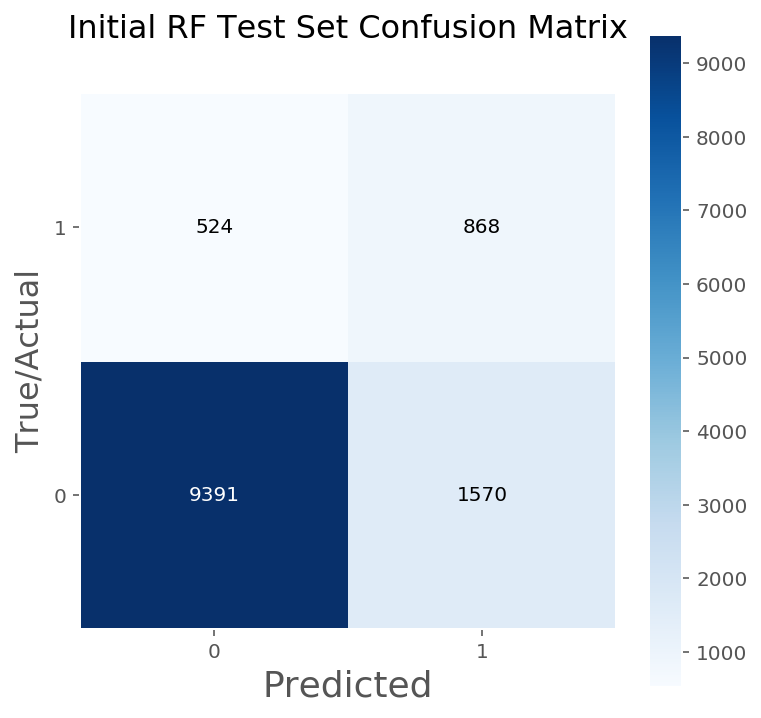

In [66]:
# Original 5-variable RF confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_rf, figsize=(6,6))
plt.title('Initial RF Test Set Confusion Matrix', y=1.08, fontsize=16)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True/Actual', fontsize=16)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

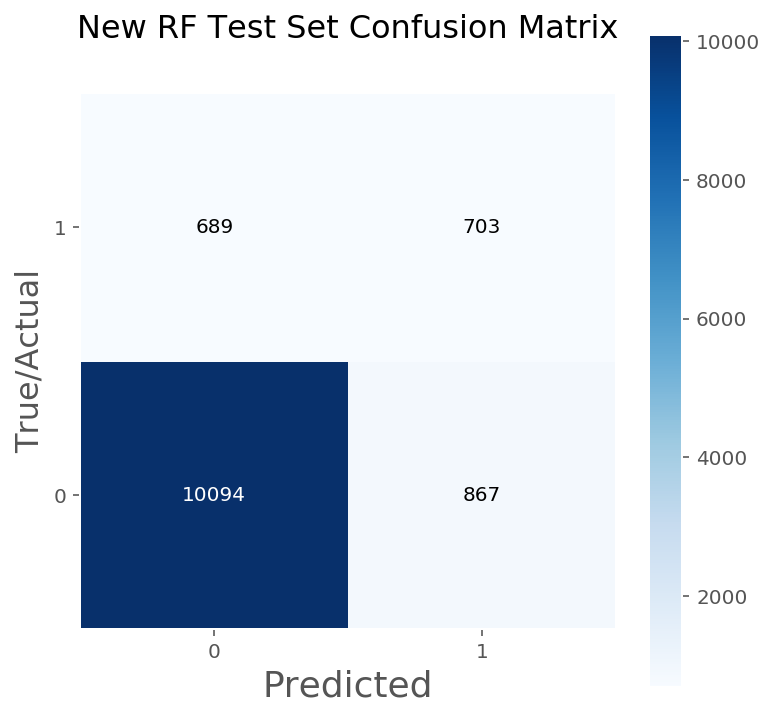

In [65]:
# RF confusion matrix on test set with threshold at 0.665605
skplt.metrics.plot_confusion_matrix(y_test, y_test_class, figsize=(6,6))
plt.title('New RF Test Set Confusion Matrix', y=1.08, fontsize=16)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True/Actual', fontsize=16)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In the new Confusion Matrix following the changed threshold, there are 703 predicted true positive observations, compared to 868 in the original model predictions. The higher threshold has reduced the number of predicted class "1" observations from 2,438 to 1,570. The new precision rate is 703/(689+703) = 50.5%, and the recall rate is 703/(703+876) = 44.5%. The original model had a precision rate of 35.6% and a recall rate of 62.4%. 

#### In other words, the original model was better at picking true positive observations from among the actual positive observations in the dataset (i.e. had a higher recall rate). The higher threshold, on the other hand, has delivered a higher precision rate. The new combination precision and recall rates resulted in a higher overall F1 score of 0.4747 on class "1" in the test set. I believe that the higher precision rate is preferable in this particular case because the model is now more precise (i.e. higher probability of picking a true positive from among the predicted positive observations). The point of the model after all is to predict successful subscriptions (class "1" ) to a bank term deposit from a tele-marketing campaign. 

There is always be a tradeoff between the precision and recall rates, as may be observed in output [48] with the lines crossing each other as the threshold goes from 0 to 1.0. In some cases, the tradeoff of a lower recall rate for a higher precision rate might not be desirable, for example in disease screening. But a higher precision rate with a higher overall F1 score serves this case well, in my view. In conclusion, the higher threshold has improved the performance of the 5-variable Random Forest model, such that it has achieved F1, Cohen's kappa and accuracy scores on the test set comparable to the top All-variable model discussed earlier.

# Conclusion

#### The changed-threshold 5-variable Random Forest model above achieved F1, Cohen's kappa and accuracy scores on the test set that rival the top All-variable model in the "Campaign_II" file. This demonstrates how using the precision-recall curve to shift the classification threshold of probabilitistic classifiers can add to their predictive power, especially in imbalanced datasets.